In [244]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels import distributions
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir('/Users/samspreen/Desktop/Spring2020/ECON4020/Project 2/')
data = pd.read_csv('data.csv')

In [200]:
#data = data.drop_duplicates(subset = ['Project ID','Company ID', 'Bid '],keep='first')

In [254]:
counts = data['Project ID'].groupby([data['Number of Small Business Bidders'],
                                     data['Number of Large Business Bidders']]
                                    ).count().reset_index(name='count').sort_values('count', ascending = False)
counts.head(5)

,Number of Small Business Bidders,Number of Large Business Bidders,count
10,1,3,238
1,0,3,189
9,1,2,168
2,0,4,131
11,1,4,129


### Below I am creating a datafram of the auctions with the median estimate value in order to derive the cdf and pdf of cost estimates

In [203]:
med_df = data
med = np.median(data['Estimate'])
upper = data[data['Estimate']>1.25*med]
lower = data[data['Estimate']<med/1.25]
symmetric_large = med_df[med_df['Number of Small Business Bidders']==0]
symmetric_small = med_df[med_df['Number of Large Business Bidders']==0]
sym = list(pd.Series(symmetric_large['Project ID']).unique()) + list(pd.Series(symmetric_small['Project ID']).unique())
upper_auctions = pd.Series(upper['Project ID']).unique()
lower_auctions = pd.Series(lower['Project ID']).unique()
remove = list(upper_auctions) + [796] + list(lower_auctions) + list(sym)
for i in remove: 
    i = int(i)
    med_df.drop(med_df.loc[med_df['Project ID']==i].index, inplace = True)


In [204]:
sns.set(style="darkgrid")
len(med_df)

627

In [212]:
df_sub = med_df

In [213]:
print('Total Entires:', len(df_sub))
print('Total Auctions:',len(pd.Series(df_sub['Project ID']).unique()))

Total Entires: 627
Total Auctions: 120


## Estimating cost $C_i$
### Having removed outliers from the two auctions we identified in for estimation, we are now ready to estimate the cost $C_i$ for each bidder using the following functions

In [214]:
def valuations(x):
    
    #pull the following from the data fame
    est = x['Estimate']
    n_l = x['Number of Large Business Bidders']
    n_s = x['Number of Small Business Bidders']
    
    #Subset by the number of bidders
    df_combo = df_sub[df_sub['Number of Large Business Bidders']==n_l]
    df_combo = df_combo[df_combo['Number of Small Business Bidders']==n_s]
    
    #subset the data from above so that we can draw the distributions
    small_df = df_combo[df_combo['Small Business Preference']==1]
    large_df = df_combo[df_combo['Small Business Preference']==0]
    
    small_g = sm.nonparametric.KDEMultivariateConditional(endog=small_df['Bid '], 
                                                          exog=small_df['Estimate'], 
                                                          dep_type='c',indep_type='c', bw='normal_reference')
    
    large_g = sm.nonparametric.KDEMultivariateConditional(endog=large_df['Bid '], 
                                                          exog=large_df['Estimate'], 
                                                          dep_type='c',indep_type='c', bw='normal_reference')
    if x['Small Business Preference'] == 0:
        bid = x['Bid '] 
        p1 = (n_l-1) * large_g.pdf([bid],[est]) / (1 - large_g.cdf([bid],[est]))
        p2 = (1.05*n_s) * small_g.pdf([1.05*bid],[est]) / (1-small_g.cdf([1.05*bid],[est]))
    
        cost = bid - (1 / (p1 + p2))
        
    if x['Small Business Preference'] == 1:
        bid = x['Bid '] 
        p3 = n_l * large_g.pdf([bid/1.05],[est]) / 1.05*(1-large_g.cdf([bid/1.05],[est]))
        p4 = (n_s-1) * small_g.pdf([bid],[est]) / (1 - small_g.cdf([bid],[est]))
       
        cost = bid - (1 / (p3 + p4))
    
    return float(cost)


In [215]:
df_sub['Cost Estimate'] = df_sub.apply(valuations, axis=1)

In [216]:
print('Number of Negative Cost Valuations:',sum( (df_sub['Cost Estimate'] < 0) * 1))

Number of Negative Cost Valuations: 23


In [217]:
#This code removes the auctions with these negative cost valuations.
neg_vals = df_sub[df_sub['Cost Estimate']<0]
neg_auctions = pd.Series(neg_vals['Project ID']).unique()
remove = list(neg_auctions) 
for i in remove:
    i = int(i)
    df_sub.drop(df_sub.loc[df_sub['Project ID']==i].index, inplace = True)


Text(0.5, 0, 'Cost')

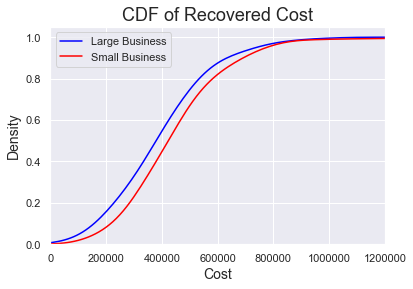

In [218]:
small_cost = df_sub[df_sub['Small Business Preference']==0]
large_cost = df_sub[df_sub['Small Business Preference']==1]
max_cost = max(large_cost['Cost Estimate'])
p1=sns.kdeplot(data=large_cost[large_cost['Cost Estimate']<max_cost]['Cost Estimate'],cumulative=True,color='Blue',
           label = 'Large Business')
p1=sns.kdeplot(data=small_cost[small_cost['Cost Estimate']<max_cost]['Cost Estimate'],cumulative=True,color='Red',
           label = 'Small Business')
p1.set_xlim(0,1200000)
p1.set_title('CDF of Recovered Cost', fontsize=18)
p1.set_ylabel('Density', fontsize=14)
p1.set_xlabel('Cost', fontsize=14)
#p1.figure.savefig('cdf_both.jpg', format='jpeg', dpi=800)

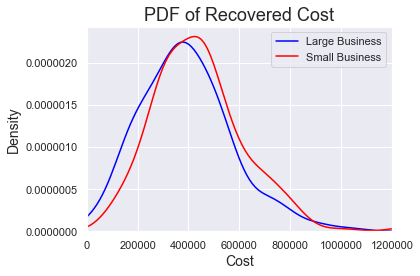

In [253]:
p1=sns.kdeplot(data=large_cost[large_cost['Cost Estimate']<max_cost]['Cost Estimate'],cumulative=False,color='Blue',
           label = 'Large Business')
p1=sns.kdeplot(data=small_cost[small_cost['Cost Estimate']<max_cost]['Cost Estimate'],cumulative=False,color='Red',
           label = 'Small Business')


p1.set_xlim(0,1200000)
plt.title('PDF of Recovered Cost', fontsize=18)
plt.xlabel('Cost', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tight_layout()
#p1.figure.savefig('pdf_both', format='pdf', dpi=800)

## Counterfactual Analysis:
### For the counterfactual analysis we will select to asymmetric bidding cases and their respective symmetric cases (see writeup for details) and we will estimate the costs for both cases as they were not included above. We will then be building regression based off of the symmetric cases and then using them to predict the values for our asymmetric case. A detailed explanation of this is included in the paper.

In [255]:
#The Bidder Combination we will be using
df_sub = data[data['Number of Small Business Bidders']==2]   
df_sub = df_sub[df_sub['Number of Large Business Bidders']==2]
df_sub2 = data[data['Number of Small Business Bidders']==2]   
df_sub2 = df_sub2[df_sub2['Number of Large Business Bidders']==3]

### First we want to remove outliers from the 2 small, 2 large bidder combination which we have stored in the dataframe names 'df_sub'

In [256]:
#This cell creates the KDE plot for the density of bids for 2 small 2 large bidders.
#it is clearly very right skewed
#p1 = sns.distplot(df_sub['Bid '],kde = True, bins = 40, color='#0b559f')
#p1.set_title('Bid Density', fontsize=18)
#p1.set_ylabel('Density', fontsize=14)
#p1.set_xlabel('Bid', fontsize=14)

In [257]:
#This cell drops all auctions with bids in the upper 25% quantile. 
#IMPORTANT NOTE: if your run this cell more than once without reloading in the data
#than you are removing even more data. Ex) if your run it twice, you remove the upper 25%
#quantile auctions and then your remove the upper 25% quantile of that distribution.
#Solution: reload in the data in the above cells if you need to change the quantile param.
upper_quant = float(df_sub['Bid '].quantile(0.70))
upper = df_sub[df_sub['Bid '] > upper_quant]
upper_auctions = pd.Series(upper['Project ID']).unique()
remove = list(upper_auctions) + [2050,2115] 
for i in remove:
    i = int(i)
    df_sub.drop(df_sub.loc[df_sub['Project ID']==i].index, inplace = True)

In [258]:
#p1 = sns.distplot(df_sub['Bid '],kde = True, bins = 20, color='#0b559f')
#p1.set_title('Bid Density', fontsize=18)
#p1.set_ylabel('Density', fontsize=14)
#p1.set_xlabel('Bid', fontsize=14)

### Next we want to remove outliers from the 2 small 3 large bidder combinations which is stored in the dataframe 'df_sub2'

In [259]:
#This cell creates the KDE plot for the density of bids for 2 small 3 large bidders.
#it is clearly very right skewed
#p1 = sns.distplot(df_sub2['Bid '],kde = True, bins = 40, color='#0b559f')
#p1.set_title('Bid Density', fontsize=18)
#p1.set_ylabel('Density', fontsize=14)
#p1.set_xlabel('Bid', fontsize=14)

In [260]:
#This cell drops all auctions with bids in the upper 25% quantile. 
#IMPORTANT NOTE: if your run this cell more than once without reloading in the data
#than you are removing even more data. Ex) if your run it twice, you remove the upper 25%
#quantile auctions and then your remove the upper 25% quantile of that distribution.
#Solution: reload in the data in the above cells if you need to change the quantile param.
upper_quant = float(df_sub2['Bid '].quantile(0.7))
upper = df_sub2[df_sub2['Bid '] > upper_quant]
upper_auctions = pd.Series(upper['Project ID']).unique()
remove = list(upper_auctions) + [796]
for i in remove:
    i = int(i)
    df_sub2.drop(df_sub2.loc[df_sub2['Project ID']==i].index, inplace = True)

In [261]:
#sns.set(style="darkgrid")
#p1 = sns.distplot(df_sub2['Bid '],kde = True, bins = 20, color='#0b559f')
#p1.set_title('Bid Density', fontsize=18)
#p1.set_ylabel('Density', fontsize=14)
#p1.set_xlabel('Bid', fontsize=14)

In [262]:
#combine the 2 cleaned dataframes into 1
df_sub=pd.concat([df_sub,df_sub2])

In [265]:
df_sub['Cost Estimate']=df_sub.apply(valuations,axis=1)

In [266]:
#This code removes the auctions with these negative cost valuations.
neg_vals = df_sub[df_sub['Cost Estimate']<0]
neg_auctions = pd.Series(neg_vals['Project ID']).unique()
remove = list(neg_auctions) 
for i in remove:
    i = int(i)
    df_sub.drop(df_sub.loc[df_sub['Project ID']==i].index, inplace = True)


In [267]:
print('Total Entires:', len(df_sub))
print('Total Auctions:',len(pd.Series(df_sub['Project ID']).unique()))

Total Entires: 117
Total Auctions: 26


In [268]:
#We will use the 2 small 0 large and 2 large 0 small cases for counterfactual analysis
cf_small = data[data['Number of Small Business Bidders']==2]
cf_small = cf_small[cf_small['Number of Large Business Bidders']==0]
cf_large = data[data['Number of Small Business Bidders']==0]
cf_large2 = cf_large[cf_large['Number of Large Business Bidders']==2]
cf_large3 = cf_large[cf_large['Number of Large Business Bidders']==3]
cf_large = pd.concat([cf_large2,cf_large3])

In [269]:
#Drop Outliers
upper_quant = float(cf_small['Bid '].quantile(0.75))
upper = cf_small[cf_small['Bid '] > upper_quant]
upper_auctions = pd.Series(upper['Project ID']).unique()
remove = list(upper_auctions) 
for i in remove:
    i = int(i)
    cf_small.drop(cf_small.loc[cf_small['Project ID']==i].index, inplace = True)


In [270]:
#Drop Outliers
upper_quant = float(cf_large['Bid '].quantile(0.75))
upper = cf_large[cf_large['Bid '] > upper_quant]
upper_auctions = pd.Series(upper['Project ID']).unique()
remove = list(upper_auctions) 
for i in remove:
    i = int(i)
    cf_large.drop(cf_large.loc[cf_large['Project ID']==i].index, inplace = True)


## The function below calculates the valuations for the symmetric auctions which we will use for our counterfactual cases.

In [271]:
def symmetric_value(x):
    
    #pull the following from the data fame
    bid = x['Bid ']
    est = x['Estimate']
    n_l = x['Number of Large Business Bidders']
    n_s = x['Number of Small Business Bidders']
    preference = x['Small Business Preference']
    
    #if we are looking at the small business case
    if n_s > 0:
        
        df = cf_small[cf_small['Number of Small Business Bidders']==n_s]
    
        
        g_dist = sm.nonparametric.KDEMultivariateConditional(endog=df['Bid '], 
                                                          exog=df['Estimate'], 
                                                          dep_type='c',indep_type='c', bw='normal_reference')
        denom = (n_s-1) * g_dist.pdf([bid],[est]) /(1 - g_dist.cdf([bid],[est]))
        
        cost = bid - (1/denom)
        
        if cost < 0:
            cost = np.mean(cf_small['Bid '])
    
    #if we are looking at the large business case 
    if n_l > 0:
        
        df = cf_large[cf_large['Number of Small Business Bidders']==n_s]
        
        g_dist = sm.nonparametric.KDEMultivariateConditional(endog=df['Bid '], 
                                                          exog=df['Estimate'], 
                                                          dep_type='c',indep_type='c', bw='normal_reference')
        denom = (n_l-1) * g_dist.pdf([bid],[est]) /(1 - g_dist.cdf([bid],[est]))
        
        cost = bid - (1/denom)
        
        if cost < 0:
            cost = np.mean(cf_large['Bid '])
    
    return float(cost)
   

In [283]:
print('Total Entires:', len(df_sub))
print('Total Auctions:',len(pd.Series(df_sub['Project ID']).unique()))

Total Entires: 117
Total Auctions: 26


In [272]:
cf_small['Cost Estimate'] = cf_small.apply(symmetric_value, axis=1)
cf_large['Cost Estimate'] = cf_large.apply(symmetric_value, axis=1)

In [274]:
#Create a Cost squared variable for our regression
cf_small['Cost Sq']=cf_small['Cost Estimate']**2
cf_large['Cost Sq']=cf_large['Cost Estimate']**2

### The function below takes in a bid, cost estimate, cost estimate squared and the number of bidders in an auction and from the data. If the business is small it predicts its bid using the regression trained on the symmetric small bidders case and visa versa for large businesses

In [299]:
def bid_no_disc(x):
    
    n_l = x['Number of Large Business Bidders']
    n_s = x['Number of Small Business Bidders']
    cost = x['Cost Estimate']
    cost_sq = x['Cost Estimate']**2
    estimate = x['Estimate']

    if x['Small Business Preference'] == 1:
        
     
        
        y_values_small=cf_small['Bid ']
        x_values_small=cf_small[['Cost Estimate','Cost Sq','Number of Small Business Bidders','Estimate']]
    
        model = sm.OLS(y_values_small,x_values_small).fit()  
        predicted_bid = model.predict([cost,cost_sq,n_s,estimate])
        
    if x['Small Business Preference'] == 0:
        

        
        y_values_large=cf_large['Bid ']
        x_values_large=cf_large[['Cost Estimate','Cost Sq','Number of Large Business Bidders','Estimate']]
    
        
        model = sm.OLS(y_values_large,x_values_large).fit()  
        predicted_bid = model.predict([cost,cost_sq,n_l,estimate])
        
    
    return float(predicted_bid)

In [300]:
df_sub['Bid No Discount'] = df_sub.apply(bid_no_disc,axis=1)

In [301]:
print('Total Entires:', len(df_sub))
print('Total Auctions:',len(pd.Series(df_sub['Project ID']).unique()))

Total Entires: 117
Total Auctions: 26


In [302]:
keep=['Project ID','Company ID','Bid ','Small Business Preference','rank','Cost Estimate','Bid No Discount']
results_df = df_sub[keep]
results_df['Rank w/d'] = results_df['rank']

In [303]:
auctions = pd.Series(results_df['Project ID']).unique()
data2 = pd.DataFrame()
for i in list(auctions):
    df = results_df[results_df['Project ID'] == i]
    df['Rank no/d'] = df['Bid No Discount'].rank()
    df = pd.DataFrame(df)
    data2 = data2.append(df)

ranked = data2

In [304]:
winner_d=ranked[ranked['Rank w/d']==1]
winner_no_d=ranked[ranked['Rank no/d']==1]

In [305]:
cost_no_discount=float(sum(winner_no_d['Bid No Discount']))
cost_discount=sum(winner_d['Bid '])
print('Total Cost Without Discount:', cost_no_discount)
print('Total Cost With Discount:', cost_discount)
print('Percent Change when discount implemented', 
      100*(cost_discount - cost_no_discount) / cost_no_discount)

Total Cost Without Discount: 9746417.02577869
Total Cost With Discount: 8615837.35
Percent Change when discount implemented -11.599951785239387


In [306]:
print('Average Change in Project Cost (W/D - No/D):', 
      (sum(winner_d['Bid ']) - sum(winner_no_d['Bid No Discount']))/len(winner_d))

Average Change in Project Cost (W/D - No/D): -43483.8336837958


In [307]:
avg_est=sum(df_sub[df_sub['rank']==1]['Estimate'])/len(df_sub[df_sub['rank']==1])
print('Avg. Contract Estimate:',avg_est)

Avg. Contract Estimate: 365854.1538461539


In [308]:
print('Small Wins W/Disc', sum(winner_d['Small Business Preference']))
print('Small Wins No Disct',sum(winner_no_d['Small Business Preference']))

Small Wins W/Disc 12
Small Wins No Disct 12


In [309]:
small=ranked[ranked['Small Business Preference']==1]
large=ranked[ranked['Small Business Preference']==0]

In [310]:
sm_disc=sum(small['Bid '])
sm_no=sum(small['Bid No Discount'])
lg_disc=sum(large['Bid '])
lg_no=sum(large['Bid No Discount'])

In [311]:
print('% Small Change With Discount:', 100*(sm_disc-sm_no)/sm_no)
print('% Large Change With Discount:', 100*(lg_disc-lg_no)/lg_no)

% Small Change With Discount: -1.1616645720773129
% Large Change With Discount: -5.1370591312372085
